In [7]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet('./data/train-data.parquet')
df_trump = pd.read_json('./data/tweets.json')
display(df.head())
display(df_trump.head())

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other
0,47777,10873,3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
1,39773,2790,2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
2,47101,3379,3,4.0,4.0,4.0,4.0,4.0,4.0,0.0,...,False,False,False,False,True,False,False,False,True,False
3,43625,7365,3,2.0,3.0,2.0,1.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
4,12538,488,0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,False,False,False,False,False,False,False,False,True,False


,date,favorites,id,isRetweet,retweets,text
0,2024-11-04 10:20:38,3983,113425359755307360,False,1554,<p></p>
1,2024-11-04 10:20:27,2527,113425359034120560,False,713,"<p>Join me live in Raleigh, North Carolina at ..."
2,2024-11-04 09:56:53,4816,113425266314029296,False,1329,"<p><a href=""https://links.truthsocial.com/link..."
3,2024-11-04 09:36:27,6672,113425185981054000,False,2232,<p>MAKE AMERICA GREAT AGAIN!</p>
4,2024-11-04 09:17:13,5338,113425110394877856,False,2052,<p>“AMERICA IS BEING INVADED”</p>


In [3]:
# map all columns with true/false labels to 1 for true and 0 for false
def map_labels(df):
    for col in df.columns:
        if df[col].dtype == 'bool':
            df[col] = df[col].astype(int)
        elif np.issubdtype(df[col].dtype, np.floating):
            if col == "hate_speech_score":
                df[col] = (df[col] > 0.5).astype(int)
            elif col == "hatespeech":
                df[col] = (df[col] > 1).astype(int)
            else:
                df[col] = (df[col] > 2).astype(int)
    return df

# drop all columns with annotator in the name
df = df.loc[:, ~df.columns.str.contains('annotator')]
df = df.drop(columns=["infitms", "outfitms", "std_err", "hypothesis", "platform"])
df = map_labels(df)
# train test split
df_train, df_test = train_test_split(df, test_size=0.4, random_state=42)
df_test, df_dev = train_test_split(df_test, test_size=0.5, random_state=42)
# df_extra, df_train = train_test_split(df, test_size=0.01, random_state=42)
# df_train, df_test = train_test_split(df_train, test_size=0.4, random_state=42)
# df_test, df_dev = train_test_split(df_test, test_size=0.5, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_dev = df_dev.reset_index(drop=True)

dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "test": Dataset.from_pandas(df_test),
    "dev": Dataset.from_pandas(df_dev)
})

In [4]:
# Calculate the percentage of positive occurrences for each numeric column in the dataframe
positive_percentages = (df.select_dtypes(include=['number']).iloc[:, 1:].sum() / len(df)) * 100

# Create a DataFrame to store the results
positive_percentages_df = positive_percentages.reset_index()
positive_percentages_df.columns = ['Label', 'Positive_Percentage']

# Sort the DataFrame by Positive_Percentage in descending order
positive_percentages_df = positive_percentages_df.sort_values(by='Positive_Percentage', ascending=False)

# Display the DataFrame
display(positive_percentages_df)

,Label,Positive_Percentage
0,sentiment,71.319602
1,respect,65.797899
2,insult,61.838650
8,attack_defend,57.799729
3,humiliate,51.388356
...,...,...
53,target_age_seniors,0.368851
62,target_disability_other,0.143114
60,target_disability_hearing_impaired,0.104754
59,target_disability_visually_impaired,0.092213


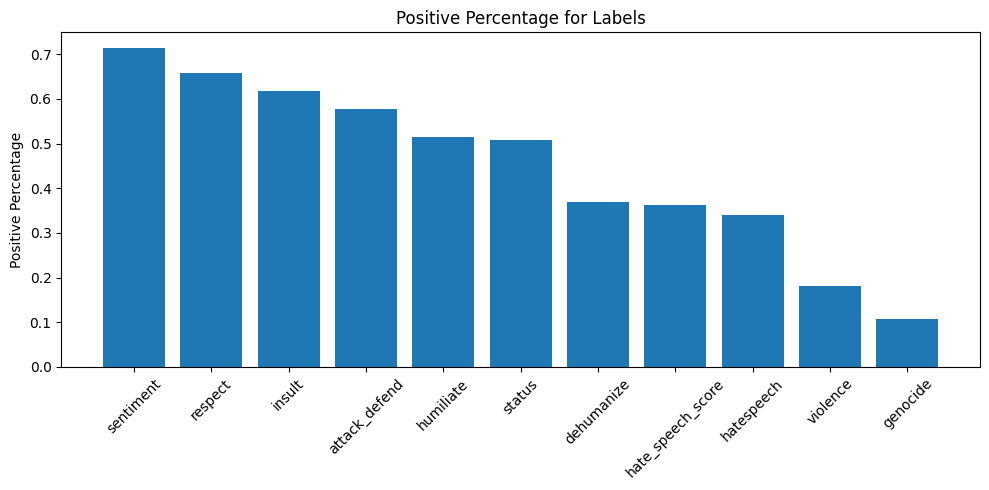

/var/folders/sn/hvdpnw3n7l35_lcfs2ppcb_80000gn/T/ipykernel_84174/3290166371.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([label[7:] for label in columns_targets], rotation=45)


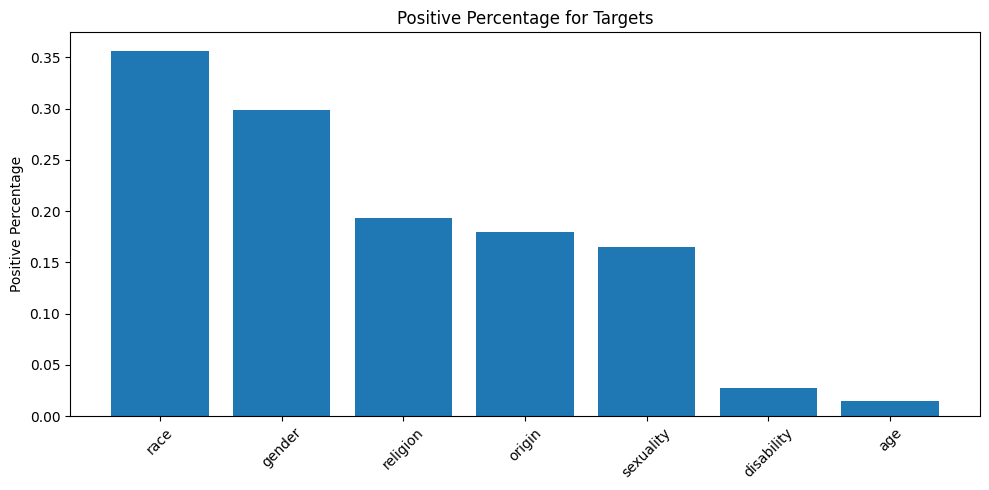

In [15]:
columns_labels = ['sentiment', 'respect', 'insult', 'attack_defend', 'humiliate', 'status', 'dehumanize', 'hate_speech_score', 'hatespeech', 'violence', 'genocide']
columns_targets = ['target_race', 'target_gender', 'target_religion', 'target_origin', 'target_sexuality', 'target_disability', 'target_age']

# Calculate the mean positive percentage for each group
labels_mean = df[columns_labels].mean()
targets_mean = df[columns_targets].mean()
# Create a bar chart for labels
fig1, ax1 = plt.subplots(figsize=(10, 5))
ax1.bar(columns_labels, labels_mean)
ax1.set_ylabel('Positive Percentage')
ax1.set_title('Positive Percentage for Labels')
ax1.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Create a bar chart for targets
fig2, ax2 = plt.subplots(figsize=(10, 5))
ax2.bar(columns_targets, targets_mean)
ax2.set_ylabel('Positive Percentage')
ax2.set_title('Positive Percentage for Targets')
ax2.tick_params(axis='x', rotation=45)
ax2.set_xticklabels([label[7:] for label in columns_targets], rotation=45)
plt.tight_layout()
plt.show()

In [17]:
labels = [label for label in dataset["train"].features.keys() if label not in ['comment_id', 'text']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels

['sentiment',
 'respect',
 'insult',
 'humiliate',
 'status',
 'dehumanize',
 'violence',
 'genocide',
 'attack_defend',
 'hatespeech',
 'hate_speech_score',
 'target_race_asian',
 'target_race_black',
 'target_race_latinx',
 'target_race_middle_eastern',
 'target_race_native_american',
 'target_race_pacific_islander',
 'target_race_white',
 'target_race_other',
 'target_race',
 'target_religion_atheist',
 'target_religion_buddhist',
 'target_religion_christian',
 'target_religion_hindu',
 'target_religion_jewish',
 'target_religion_mormon',
 'target_religion_muslim',
 'target_religion_other',
 'target_religion',
 'target_origin_immigrant',
 'target_origin_migrant_worker',
 'target_origin_specific_country',
 'target_origin_undocumented',
 'target_origin_other',
 'target_origin',
 'target_gender_men',
 'target_gender_non_binary',
 'target_gender_transgender_men',
 'target_gender_transgender_unspecified',
 'target_gender_transgender_women',
 'target_gender_women',
 'target_gender_other',

In [26]:
X_train = df_train["text"].reset_index()
y_train = df_train.drop(columns=["text"])
display(X_train.head())

,index,text
0,0,Why did I click on your profile? You gave no s...
1,1,it really doesn't matter if you don't believe ...
2,2,"Please help support nonbinary pride, add a #Tw..."
3,3,#MissionUnstapabolBossingMaine @mainedcm | Mai...
4,4,I love that you enjoy being trans.


In [27]:
max_length = X_train["text"].str.len().max()
print(f"Maximum length of text: {max_length}")

Maximum length of text: 603


In [28]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preprocess_data(examples):
  # take a batch of texts
  text = examples["text"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=512)
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  # fill numpy array
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()
  
  return encoding

In [29]:
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset["train"].column_names)

Map: 100%|██████████| 27112/27112 [00:03<00:00, 7308.77 examples/s]


In [30]:
example = encoded_dataset["train"][0]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


In [31]:
tokenizer.decode(example['input_ids'])

"[CLS] why did i click on your profile? you gave no source anyway, you just are a hateful human being. good grief. you have been given sources by others disproving your statements, but no you didn ' t, once you cited the hatesub gc, that is used only to missrepresent transgender people and to deny their existence [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [32]:
example['labels']

[1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [33]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label != 0]

['sentiment',
 'target_sexuality_bisexual',
 'target_sexuality_gay',
 'target_sexuality_lesbian',
 'target_sexuality_other',
 'target_sexuality']

In [34]:
encoded_dataset.set_format("torch")

In [80]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [135]:
batch_size = 8
metric_name = "f1"

In [136]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"bert-finetuned-sem_eval-english",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    #push_to_hub=True,
)

/Users/vikram/miniconda3/envs/ml-0451/lib/python3.9/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [138]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
    
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [139]:
encoded_dataset["train"][0]['labels'].type()

'torch.FloatTensor'

In [140]:
encoded_dataset["train"]['input_ids'][0]

tensor([  101,  1030,  6683,  2891, 21547,  1030,  7595,  5685, 21397,  7486,
         2323,  2022,  4452,  1997,  2151,  2173,  3352,  5152,  3484,  2084,
         2055,  2634,  1010,  2559,  2012,  1996,  4650,  1999,  2035,  5152,
         3484,  3032,  2085,  1012, 18883,  2015,  1998, 20474,  2015,  2071,
         2025, 21063,  1999,  1028, 19527,  2086,  1012,  2129,  2079,  2017,
         5987,  2068,  2000, 19242,  1996, 18221,  1999,  2634,  1029,  1001,
        20474,  6914, 10085,  5178,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [141]:
outputs = model(input_ids=encoded_dataset["train"]['input_ids'][0].unsqueeze(0), labels=encoded_dataset["train"][0]['labels'].unsqueeze(0))
outputs

SequenceClassifierOutput(loss=tensor(0.7002, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[ 0.4964,  0.1237,  0.7332,  0.4905,  0.4337, -0.2857,  0.2185, -0.3485,
         -0.4422, -0.5298,  0.5695,  0.0234,  0.3570,  0.1206, -0.6058, -0.3078,
         -0.4451, -0.0048, -0.6410, -0.0872, -0.2691,  0.2103,  0.2653, -0.6864,
         -0.3468, -0.0184,  0.2674, -0.7151, -0.4990,  0.1555,  0.2831, -0.0372,
          0.0360,  0.8311,  0.3228,  0.2725,  0.5254,  0.4875,  0.0399, -0.4417,
         -0.4516,  0.3269, -0.2376, -0.1142, -0.4359,  0.4867, -0.2368,  0.0204,
         -0.2572, -0.2442,  0.6405,  0.1258, -0.2876, -0.1532,  0.2366,  0.0225,
          0.2581,  0.0265,  0.1419, -0.1325, -0.3316, -0.1444, -0.3841]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [142]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["dev"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/var/folders/sn/hvdpnw3n7l35_lcfs2ppcb_80000gn/T/ipykernel_50827/1602522562.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [143]:
trainer.train()

/Users/vikram/miniconda3/envs/ml-0451/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,No log,0.324192,0.535123,0.708906,0.000000


/Users/vikram/miniconda3/envs/ml-0451/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


KeyboardInterrupt: 

In [35]:
model_path = "bert-finetuned-hate-speech"

# Load tokenizer and model
trained_model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [36]:
# Put model in eval mode
trained_model.eval()

# Create a DataLoader for the test dataset
test_loader = DataLoader(encoded_dataset['test'], batch_size=8)

results_df = pd.DataFrame(columns=['Text', 'Predicted_Values', 'Actual_Values'])

# Iterate through the test dataset and make predictions
for batch in test_loader:
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels'].int()

    decoded_texts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in input_ids]

    with torch.no_grad():
        outputs = trained_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.sigmoid(logits) > 0.5
        # Convert predictions to integers (1 or 0)
        predictions = predictions.int()

        batch_results = []
        for text, pred, actual in zip(decoded_texts, predictions.numpy(), labels.numpy()):
            batch_results.append({'Text': text, 'Predicted_Values': list(pred), 'Actual_Values': list(actual)})

        # Convert the list of results to a DataFrame
        batch_df = pd.DataFrame(batch_results)
        print(f"Processed {len(results_df) + len(batch_df)} rows so far.")

        # Concatenate the batch DataFrame with the main results DataFrame
        results_df = pd.concat([results_df, batch_df], ignore_index=True)
    
display(results_df)

Processed 8 rows so far.
Processed 16 rows so far.
Processed 24 rows so far.
Processed 32 rows so far.
Processed 40 rows so far.
Processed 48 rows so far.
Processed 56 rows so far.
Processed 64 rows so far.
Processed 72 rows so far.
Processed 80 rows so far.
Processed 88 rows so far.
Processed 96 rows so far.
Processed 104 rows so far.
Processed 112 rows so far.
Processed 120 rows so far.
Processed 128 rows so far.
Processed 136 rows so far.
Processed 144 rows so far.
Processed 152 rows so far.
Processed 160 rows so far.
Processed 168 rows so far.
Processed 176 rows so far.
Processed 184 rows so far.
Processed 192 rows so far.
Processed 200 rows so far.
Processed 208 rows so far.
Processed 216 rows so far.
Processed 224 rows so far.
Processed 232 rows so far.
Processed 240 rows so far.
Processed 248 rows so far.
Processed 256 rows so far.
Processed 264 rows so far.
Processed 272 rows so far.
Processed 280 rows so far.
Processed 288 rows so far.
Processed 296 rows so far.
Processed 304 

,Text,Predicted_Values,Actual_Values
0,> some incels give a lot but get nothing back ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,who hurt you? lol. it's comical how stupid and...,"[1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,"yes, in barbaric, authoritarian cultures that ...","[1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
3,get fucked in 2020 small son. he should start ...,"[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, ..."
4,yawovi e. he's a racist just like sodomite lem...,"[1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, ..."
...,...,...,...
27106,> got off relatively well we can't know that a...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
27107,alarming : if @ twitter lets # iran mullahs & ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
27108,nugs lauds ghanaian muslims for their immense ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
27109,get walk. piss on some desks and leave that sh...,"[1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."


In [49]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

# Convert the Predicted_Values and Actual_Values columns to numpy arrays
predicted_values_array = np.array(results_df['Predicted_Values'].tolist())
actual_values_array = np.array(results_df['Actual_Values'].tolist())

# Calculate F1 score and accuracy
f1 = f1_score(actual_values_array, predicted_values_array, average='micro')
accuracy = accuracy_score(actual_values_array, predicted_values_array)
roc_auc = roc_auc_score(actual_values_array, predicted_values_array, average='micro')

print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")

F1 Score: 0.7908309180368022
Accuracy: 0.16646379698277453
ROC AUC: 0.8714952893208041


In [59]:
from sklearn.metrics import precision_score, recall_score, f1_score
import openpyxl

# Convert the predicted and actual values to numpy arrays for easier computation
predicted_values_array = np.array(results_df['Predicted_Values'].tolist())
actual_values_array = np.array(results_df['Actual_Values'].tolist())

# Calculate accuracy, precision, recall, and F1 score for each label

label_precisions = np.round(precision_score(actual_values_array, predicted_values_array, average=None, zero_division=0), 3)
label_recalls = np.round(recall_score(actual_values_array, predicted_values_array, average=None, zero_division=0), 3)
label_f1_scores = np.round(f1_score(actual_values_array, predicted_values_array, average=None, zero_division=0), 3)
label_accuracies = np.round((predicted_values_array == actual_values_array).mean(axis=0), 3)

# Create a dictionary to map labels to their accuracies, precisions, recalls, and F1 scores
label_metrics_dict = {
    id2label[idx]: {
        'Accuracy': accuracy,
        'Precision': label_precisions[idx],
        'Recall': label_recalls[idx],
        'F1_Score': label_f1_scores[idx]
    }
    for idx, accuracy in enumerate(label_accuracies)
}

# Convert the dictionary to a DataFrame
accuracy_df = pd.DataFrame.from_dict(label_metrics_dict, orient='index').reset_index()
accuracy_df.rename(columns={'index': 'Label'}, inplace=True)
label_accuracy_dict = {id2label[idx]: accuracy for idx, accuracy in enumerate(label_accuracies)}
# Add a column for the number of positive occurrences in each label
accuracy_df['Positive_Occurrences'] = [actual_values_array[:, idx].sum() for idx in range(actual_values_array.shape[1])]
total_num = actual_values_array.shape[0]
negative_occurrences = total_num - np.array(accuracy_df['Positive_Occurrences'])
majority_occurrences = np.maximum(accuracy_df['Positive_Occurrences'], negative_occurrences)
base_line = majority_occurrences / total_num
accuracy_df['Baseline Accuracy'] = base_line

# Sort the DataFrame by accuracy in descending order
# Split the DataFrame into two: one with labels that don't have "target" in the name and the other with "target" labels
non_target_labels_df = accuracy_df[~accuracy_df['Label'].str.contains('target')]
target_labels_df = accuracy_df[accuracy_df['Label'].str.contains('target')]

# Sort both DataFrames by 'Positive_Occurrences' in descending order
non_target_labels_df = non_target_labels_df.sort_values(by='Positive_Occurrences', ascending=False)
target_labels_df = target_labels_df.sort_values(by='Positive_Occurrences', ascending=False)

# Display the sorted DataFrame
display(non_target_labels_df)
display(target_labels_df)

# Save the accuracy DataFrame to a CSV file
non_target_labels_df.to_excel('results/hate_speech_metrics.xlsx', index=False)
# Save the target labels DataFrame to a CSV file
target_labels_df.to_excel('results/target_metrics.xlsx', index=False)

,Label,Accuracy,Precision,Recall,F1_Score,Positive_Occurrences,Baseline Accuracy
0,sentiment,0.857,0.888,0.915,0.901,19330,0.712995
1,respect,0.853,0.879,0.901,0.890,17883,0.659622
2,insult,0.831,0.851,0.882,0.866,16760,0.618199
8,attack_defend,0.819,0.828,0.868,0.847,15709,0.579433
3,humiliate,0.783,0.776,0.813,0.794,13949,0.514514
4,status,0.767,0.760,0.796,0.778,13877,0.511859
5,dehumanize,0.769,0.689,0.700,0.694,10165,0.625060
10,hate_speech_score,0.936,0.903,0.924,0.913,9821,0.637749
9,hatespeech,0.835,0.766,0.747,0.756,9278,0.657777
6,violence,0.914,0.794,0.711,0.750,4928,0.818229


,Label,Accuracy,Precision,Recall,F1_Score,Positive_Occurrences,Baseline Accuracy
19,target_race,0.885,0.870,0.801,0.834,9735,0.640921
42,target_gender,0.904,0.830,0.853,0.841,8046,0.703220
40,target_gender_women,0.923,0.814,0.811,0.812,5572,0.794475
28,target_religion,0.949,0.890,0.845,0.867,5325,0.803585
34,target_origin,0.901,0.762,0.640,0.696,4805,0.822766
12,target_race_black,0.952,0.874,0.843,0.859,4667,0.827856
48,target_sexuality,0.934,0.838,0.740,0.786,4470,0.835122
44,target_sexuality_gay,0.961,0.867,0.780,0.821,3119,0.884954
31,target_origin_specific_country,0.916,0.634,0.452,0.528,2805,0.896536
26,target_religion_muslim,0.964,0.824,0.780,0.801,2526,0.906827


In [83]:
from bs4 import BeautifulSoup

def clean_html(raw_html):
    # Parse HTML
    soup = BeautifulSoup(raw_html, "html.parser")
    # Get plain text
    return soup.get_text(separator=" ", strip=True)

In [88]:
df_trump['isRetweet'] = df_trump['isRetweet'].astype(bool)
df_trump['text'] = df_trump['text'].apply(lambda x: clean_html(x))
# remove all rows with empty text
df_trump = df_trump[df_trump['text'].str.strip() != '']

/var/folders/sn/hvdpnw3n7l35_lcfs2ppcb_80000gn/T/ipykernel_37695/3529670925.py:5: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  soup = BeautifulSoup(raw_html, "html.parser")


In [89]:
# smaller_df['text'] = smaller_df['text'].astype(str)
display(df_trump.head(10))

,date,favorites,id,isRetweet,retweets,text
1,2024-11-04 10:20:27,2527,113425359034120560,False,713,"Join me live in Raleigh, North Carolina at 10:..."
2,2024-11-04 09:56:53,4816,113425266314029296,False,1329,https:// swampthevoteusa.com/
3,2024-11-04 09:36:27,6672,113425185981054000,False,2232,MAKE AMERICA GREAT AGAIN!
4,2024-11-04 09:17:13,5338,113425110394877856,False,2052,“AMERICA IS BEING INVADED”
8,2024-11-04 01:34:55,15593,113423292553721168,False,4014,"A great day in Pennsylvania, North Carolina, a..."
9,2024-11-04 00:59:10,12013,113423151971796160,False,2717,RT: https://truthsocial.com/users/realDonaldTr...
10,2024-11-03 22:13:34,14659,113422500803916096,False,4097,Mimi Ramirez-Rodriguez was kidnapped and murde...
11,2024-11-03 22:09:57,12277,113422486548204144,False,2733,"THANK YOU—MACON, GEORGIA! https:// swampthevot..."
12,2024-11-03 22:09:00,0,113422482812310384,True,0,RT @ TeamTrump PRESIDENT TRUMP: Under my leade...
13,2024-11-03 22:08:55,0,113422482474891328,True,0,RT @ TeamTrump Kamala talks about fixing the e...


In [90]:
dataset_trump = DatasetDict({
    "trump": Dataset.from_pandas(df_trump)
})
# dataset_trump.set_format("torch")
# dataset_trump

def process(examples):
    # take a batch of texts
    text = examples["text"]
    # encode them
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=512)
    return encoding

dataset_trump = dataset_trump.map(process, batched=True, remove_columns=dataset_trump["trump"].column_names)
dataset_trump.set_format("torch")

Map: 100%|██████████| 76238/76238 [00:09<00:00, 8264.41 examples/s]


In [93]:
# Put model in eval mode
trained_model.eval()

# Create a DataLoader for the test dataset
trump_loader = DataLoader(dataset_trump['trump'], batch_size=8)

trump_results = pd.DataFrame(columns=['Text', 'Predicted_Values'])

# Iterate through the test dataset and make predictions
for batch in trump_loader:
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']

    decoded_texts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in input_ids]

    with torch.no_grad():
        outputs = trained_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.sigmoid(logits) > 0.5
        # Convert predictions to integers (1 or 0)
        predictions = predictions.int()

        batch_results = []
        for text, pred in zip(decoded_texts, predictions.numpy()):
            batch_results.append({'Text': text, 'Predicted_Values': list(pred)})

        # Convert the list of results to a DataFrame
        batch_df = pd.DataFrame(batch_results)
        print(f"Processed {len(trump_results) + len(batch_df)} rows so far.")

        # Concatenate the batch DataFrame with the main results DataFrame
        trump_results = pd.concat([trump_results, batch_df], ignore_index=True)
    
display(trump_results)

Processed 8 rows so far.
Processed 16 rows so far.
Processed 24 rows so far.
Processed 32 rows so far.
Processed 40 rows so far.
Processed 48 rows so far.
Processed 56 rows so far.
Processed 64 rows so far.
Processed 72 rows so far.
Processed 80 rows so far.
Processed 88 rows so far.
Processed 96 rows so far.
Processed 104 rows so far.
Processed 112 rows so far.
Processed 120 rows so far.
Processed 128 rows so far.
Processed 136 rows so far.
Processed 144 rows so far.
Processed 152 rows so far.
Processed 160 rows so far.
Processed 168 rows so far.
Processed 176 rows so far.
Processed 184 rows so far.
Processed 192 rows so far.
Processed 200 rows so far.
Processed 208 rows so far.
Processed 216 rows so far.
Processed 224 rows so far.
Processed 232 rows so far.
Processed 240 rows so far.
Processed 248 rows so far.
Processed 256 rows so far.
Processed 264 rows so far.
Processed 272 rows so far.
Processed 280 rows so far.
Processed 288 rows so far.
Processed 296 rows so far.
Processed 304 

,Text,Predicted_Values
0,"join me live in raleigh, north carolina at 10 ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,https : / / swampthevoteusa. com /,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,make america great again!,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,“ america is being invaded ”,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
4,"a great day in pennsylvania, north carolina, a...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
76233,""" "" my persona will never be that of a wallflo...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
76234,new blog post : celebrity apprentice finale an...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
76235,donald trump reads top ten financial tips on l...,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
76236,donald trump will be appearing on the view tom...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


In [94]:
# save the trump results to a CSV file
trump_results.to_csv('trump_results.csv', index=False)

In [46]:
trump_results = pd.read_csv('results/trump_results_percentages.csv')
display(trump_results.head(10))

,Text,Predicted_Values
0,"join me live in raleigh, north carolina at 10 ...","[0.13029441, 0.05716639, 0.036505666, 0.038440..."
1,https : / / swampthevoteusa. com /,"[0.47514215, 0.28255087, 0.24085581, 0.2377170..."
2,make america great again!,"[0.6128853, 0.51765984, 0.36648268, 0.20248401..."
3,“ america is being invaded ”,"[0.7795842, 0.5373616, 0.3999241, 0.23030725, ..."
4,"a great day in pennsylvania, north carolina, a...","[0.010707866, 0.006450327, 0.004465772, 0.0058..."
5,rt : https : / / truthsocial. com / users / re...,"[0.4073409, 0.33201855, 0.20497209, 0.1250654,..."
6,mimi ramirez - rodriguez was kidnapped and mur...,"[0.85492975, 0.7906267, 0.6579421, 0.48886132,..."
7,"thank you — macon, georgia! https : / / swampt...","[0.012053081, 0.010422375, 0.006891374, 0.0077..."
8,rt @ teamtrump president trump : under my lead...,"[0.50395125, 0.20935963, 0.15388672, 0.1149284..."
9,rt @ teamtrump kamala talks about fixing the e...,"[0.45012647, 0.16667789, 0.12115431, 0.0830540..."


In [47]:
# Ensure labels is converted to a list
labels_list = list(labels)
print(labels_list)

# Convert the Predicted_Values column from string representation to a list
trump_results['Predicted_Values'] = trump_results['Predicted_Values'].apply(eval)
# Create a DataFrame from the Predicted_Values column
predicted_values_df = pd.DataFrame(trump_results['Predicted_Values'].tolist(), columns=labels_list)

# Concatenate the original DataFrame with the new DataFrame
trump_results_expanded = pd.concat([trump_results.drop(columns=['Predicted_Values']), predicted_values_df], axis=1)

# Display the expanded DataFrame
display(trump_results_expanded)

['sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize', 'violence', 'genocide', 'attack_defend', 'hatespeech', 'hate_speech_score', 'target_race_asian', 'target_race_black', 'target_race_latinx', 'target_race_middle_eastern', 'target_race_native_american', 'target_race_pacific_islander', 'target_race_white', 'target_race_other', 'target_race', 'target_religion_atheist', 'target_religion_buddhist', 'target_religion_christian', 'target_religion_hindu', 'target_religion_jewish', 'target_religion_mormon', 'target_religion_muslim', 'target_religion_other', 'target_religion', 'target_origin_immigrant', 'target_origin_migrant_worker', 'target_origin_specific_country', 'target_origin_undocumented', 'target_origin_other', 'target_origin', 'target_gender_men', 'target_gender_non_binary', 'target_gender_transgender_men', 'target_gender_transgender_unspecified', 'target_gender_transgender_women', 'target_gender_women', 'target_gender_other', 'target_gender', 'target_sexuality_bisex

,Text,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech,hate_speech_score,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,target_race_other,target_race,target_religion_atheist,target_religion_buddhist,target_religion_christian,target_religion_hindu,target_religion_jewish,target_religion_mormon,target_religion_muslim,target_religion_other,target_religion,target_origin_immigrant,target_origin_migrant_worker,target_origin_specific_country,target_origin_undocumented,target_origin_other,target_origin,target_gender_men,target_gender_non_binary,target_gender_transgender_men,target_gender_transgender_unspecified,target_gender_transgender_women,target_gender_women,target_gender_other,target_gender,target_sexuality_bisexual,target_sexuality_gay,target_sexuality_lesbian,target_sexuality_straight,target_sexuality_other,target_sexuality,target_age_children,target_age_teenagers,target_age_young_adults,target_age_middle_aged,target_age_seniors,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability
0,"join me live in raleigh, north carolina at 10 ...",0.130294,0.057166,0.036506,0.038440,0.055267,0.028965,0.017823,0.007042,0.032363,0.018350,0.000078,0.004816,0.299482,0.023172,0.012374,0.015737,0.006051,0.021343,0.013332,0.438256,0.000925,0.000955,0.004234,0.001234,0.000822,0.000738,0.003378,0.002537,0.003993,0.012272,0.006126,0.107136,0.015226,0.025201,0.221085,0.056360,0.006237,0.003383,0.002696,0.003787,0.020134,0.002834,0.071823,0.007658,0.016757,0.006092,0.008299,0.008403,0.024007,0.006237,0.007828,0.012071,0.004088,0.002934,0.000799,0.026959,0.001679,0.000696,0.002372,0.000251,0.000444,0.002896,0.000403,0.005776
1,https : / / swampthevoteusa. com /,0.475142,0.282551,0.240856,0.237717,0.208206,0.143037,0.005275,0.001921,0.090805,0.032618,0.000698,0.012460,0.207856,0.254484,0.023130,0.047282,0.033068,0.022576,0.062926,0.252028,0.007668,0.005263,0.008519,0.004748,0.007920,0.007253,0.001477,0.011291,0.004923,0.035339,0.033960,0.037071,0.043764,0.031196,0.106815,0.023386,0.020113,0.034079,0.017219,0.019967,0.294857,0.018676,0.248142,0.020613,0.020697,0.034796,0.038324,0.029320,0.053173,0.044392,0.051536,0.062307,0.030631,0.021005,0.005421,0.152097,0.008222,0.006989,0.013800,0.001491,0.003875,0.017933,0.005545,0.041418
2,make america great again!,0.612885,0.517660,0.366483,0.202484,0.284783,0.092159,0.013462,0.004191,0.351183,0.016984,0.002510,0.004882,0.007826,0.008691,0.014095,0.003053,0.002580,0.005633,0.021487,0.024073,0.000534,0.000519,0.003725,0.001178,0.002539,0.000693,0.002163,0.003559,0.006211,0.087403,0.018084,0.825620,0.026455,0.042374,0.961535,0.003237,0.000926,0.000747,0.000828,0.000672,0.009291,0.000541,0.014645,0.001571,0.002594,0.001055,0.001550,0.001395,0.003702,0.001756,0.001490,0.001946,0.000759,0.000493,0.000118,0.003358,0.000420,0.000313,0.000384,0.000078,0.000084,0.000581,0.000111,0.001482
3,“ america is being invaded ”,0.779584,0.537362,0.399924,0.230307,0.355624,0.120650,0.067212,0.021670,0.504347,0.023810,0.003448,0.013965,0.010166,0.066051,0.030914,0.010213,0.009598,0.021561,0.030452,0.112470,0.000410,0.000591,0.002286,0.001234,0.001481,0.000618,0.002553,0.002371,0.003836,0.260155,0.074274,0.765347,0.236321,0.086547,0.970647,0.006345,0.000523,0.000595,0.000910,0.000617,0.003656,0.000491,0.009241,0.000968,0.001802,0.001020,0.001220,0.001454,0.002208,0.002586,0.001831,0.001919,0.001067,0.000712,0.000131,0.003442,0.000260,0.000189,0.000363,0.000076,0.000108,0.000593,0.000111,0.000846
4,"a great day in pennsylvania, north carolina, a...",0.010708,0.006450,0.004466,0.005886,0.012888,0.009289,0.008341,0.006995,0.006462,0.002734,0.000016,0.018678,0.015509,0.030747,0.026785,0.0

In [148]:
# Convert numeric columns to 1 if greater than 0.5, else 0
trump_results_expanded = trump_results_expanded.applymap(lambda x: 1 if isinstance(x, (int, float)) and x > 0.5 else (0 if isinstance(x, (int, float)) else x))

# Display the updated DataFrame
display(trump_results_expanded.head())

/var/folders/sn/hvdpnw3n7l35_lcfs2ppcb_80000gn/T/ipykernel_37695/617836337.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  trump_results_expanded = trump_results_expanded.applymap(lambda x: 1 if isinstance(x, (int, float)) and x > 0.5 else (0 if isinstance(x, (int, float)) else x))


,Text,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,...,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability
0,"join me live in raleigh, north carolina at 10 ...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,https : / / swampthevoteusa. com /,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,make america great again!,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,“ america is being invaded ”,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,"a great day in pennsylvania, north carolina, a...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [149]:
# Ensure the original df_trump DataFrame has the necessary columns
df_trump = df_trump[['text', 'date', 'favorites', 'isRetweet', 'retweets']]

# Merge trump_results_expanded with df_trump on the 'text' column
trump_results_expanded = pd.concat([trump_results_expanded.reset_index(drop=True), df_trump.reset_index(drop=True)], axis=1)

# Drop the duplicate 'text' column after merging
trump_results_expanded = trump_results_expanded.drop(columns=['text'])

# Display the updated DataFrame
display(trump_results_expanded.head())

,Text,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,...,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability,date,favorites,isRetweet,retweets
0,"join me live in raleigh, north carolina at 10 ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2024-11-04 10:20:38,3983,False,1554
1,https : / / swampthevoteusa. com /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2024-11-04 10:20:27,2527,False,713
2,make america great again!,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2024-11-04 09:56:53,4816,False,1329
3,“ america is being invaded ”,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2024-11-04 09:36:27,6672,False,2232
4,"a great day in pennsylvania, north carolina, a...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2024-11-04 09:17:13,5338,False,2052


In [150]:
# Reorder columns
columns = ['Text', 'date', 'favorites', 'isRetweet', 'retweets'] + [col for col in trump_results_expanded.columns if col not in ['Text', 'date', 'favorites', 'isRetweet', 'retweets']]
trump_results_expanded = trump_results_expanded[columns]
trump_results_expanded = trump_results_expanded.rename(columns={'Text': 'text'})

# Display the updated DataFrame
display(trump_results_expanded.head())

,text,date,favorites,isRetweet,retweets,sentiment,respect,insult,humiliate,status,...,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability
0,"join me live in raleigh, north carolina at 10 ...",2024-11-04 10:20:38,3983,False,1554,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,https : / / swampthevoteusa. com /,2024-11-04 10:20:27,2527,False,713,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,make america great again!,2024-11-04 09:56:53,4816,False,1329,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,“ america is being invaded ”,2024-11-04 09:36:27,6672,False,2232,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"a great day in pennsylvania, north carolina, a...",2024-11-04 09:17:13,5338,False,2052,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
trump_results_expanded.to_csv('results/trump_results_expanded.csv', index=False)